<p align="center"><img src="https://github.com/uchiharon/ANN-Overfitting-Lab/blob/main/Images/University_of_Texas_at_Austin_seal.svg.png?raw=true" width="200" height="200" /></p>

# Overfit Artificial Neural Network

### **Emmanuel Ikpesu**
#### **Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering**
##### [LinkedIn](https://www.linkedin.com/in/emmanuel-ikpesu-393708132/) | [Twitter](https://twitter.com/thedatahokage) | [GitHub](https://github.com/uchiharon) 

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


## Introduction
Would you believe me if I told you this entire project was built by *ChatGPT?* Your answer might be a confident “*Yes!*”—and I wouldn’t blame you. The truth is, while *ChatGPT* helped with a significant portion of the project, I was the one steering the ship.<br>
Now pause and think: why are modern *Artificial Intelligence (AI)* systems so good at what they do? The answer lies in **Artificial Neural Networks (ANNs)**—*powerful models capable of learning from almost any kind of data*: tables, text, audio, video... You name it.<br>
But here's the catch: like most *Machine Learning (ML)* models, **we want ANNs to learn meaningful patterns—not just memorize everything**. When a model starts learning **noise** instead of **general patterns**—*like learning the melody of a song versus memorizing every background sound*—it leads to a common issue called **overfitting**.<br>
This project is designed to help you understand overfitting—*what it is, how to recognize it, and how to prevent it*—so you have something cool to say at your next dinner party (as Dr. Pyrcz would put it).


### Executive Summary
#### Gap:
Artificial Neural Networks (ANNs) are powerful tools for modeling nonlinear relationships in data, but they are also prone to overfitting—where the model performs well on training data but poorly on unseen data. This lab investigates the sensitivity of ANNs to architectural and training hyperparameters, and seeks to answer: What factors contribute most to overfitting in neural networks, and how can they be controlled?
#### Approach:
An interactive ANN model was implemented to simulate predictive regression tasks with synthetic noisy data. Various hyperparameters—such as number of epochs, dropout rate, number of hidden layers and nodes, learning rate, and batch size—were explored. Visualizations were used to demonstrate model performance under different settings, particularly observing overfitting patterns between training and testing results.
#### Lessons Learned:
-   Epoch count is a major contributor to overfitting—higher values often lead to memorization of training data.
-   Dropout helps mitigate overfitting by randomly disabling nodes, though it may slightly increase prediction error.
-   Constant-sized hidden layers promote overfitting compared to gradually reduced architectures.
-   Learning rate plays a delicate role: if too high, the model may diverge or overfit quickly; if too low, it may underfit or train inefficiently.
-   Model flexibility must be balanced with proper regularization to achieve good generalization.
#### Recommendations:
-   Apply early stopping or use lower epoch counts to prevent unnecessary training past the optimal point.
-   Introduce dropout layers where appropriate to promote model robustness.
-   Consider decreasing the number of hidden nodes in deeper layers to reduce model complexity.
-   Tune learning rate carefully, potentially using learning rate schedules or search strategies to find the optimal value.
-   Use visualization and validation performance as feedback loops to guide model adjustments iteratively.

## Steps for Building My ANN Lab (OUTLINE) 📘  <a id="outline"></a>

[Things to Try](#things-to-try-)

[ANN Overview](#ann-overview)

[Import Packages](#import-packages)

[Lab Functions](#lab-functions)
- Data generator
- Model architecture designer

[Overfitting Lab Development](#overfitting-lab-development)
- Define number of realizations
- Run sensitivity analysis on each hyperparameter while keeping others as inputted
- Build desired model
- Visualize final result

[Overfitting Lab Demo](#overfitting-lab-interactive-demonstration)

[Observations / Conclusion](#observations-)

[About Author](#about-the-author)

## Things to Try
[🔝 Back to Outline](#outline)
-   Vary the Number of Hidden Layers and Neurons
    - What happens to training vs. validation error as you increase model capacity?
- Adjust Dropout Rate
    - Try dropout values between 0 and 0.5. How does regularization affect overfitting?
- Experiment with Activation Functions
    - Use ReLU, tanh, and sigmoid for the hidden layers. Which one results in better generalization?
- Modify Batch Size
    - Try small (16) vs. large (128) batches. Does a noisier gradient help regularize the model?
- Compare Optimizers
    - Use Adam, SGD, and RMSprop. Which one converges faster or helps avoid overfitting?
- Vary the Epoch
    -  How does it make your model perform/overfit?

🚀 **Pro-Tip: Use Sensitivity Plot for Better Hyperparameter Tuning**

## ANN Overview 
[🔝 Back to Outline](#outline)

An ANN (Artificial Neural Network) is a machine learning model inspired by how the human brain works. It’s a type of algorithm that learns from data by mimicking how neurons in the brain activate and pass signals to each other. It is a collection of simple interconnected algorithms that process information in response to external input.
<p align="center">
    <img src="https://github.com/uchiharon/ANN-Overfitting-Lab/blob/main/Images/ANN.png?raw=true" width="850" height="300" />

</p>
An ANN is made up of layers:

- Input layer – where data enters the model
- Hidden layers – where the network processes the data through neurons (nodes)
- Output layer – where predictions are made

🔧 What Is It Used For?
- Image recognition (like classifying lithology types)
- Natural language processing (like sentiment analysis)
- Forecasting and prediction (like real-time Geothermal well temperature prediction)
- Robotics (like automated drilling)
- Finance, medical diagnosis, and more (like production forecase)

_____________________
### ANN Key Components Include:
#### Perceptrons (Nodes)
These are the building blockers of neural networks. A Perceptron is a single-layer neural network that makes decisions by weighing input features. It's made up of a **Linear Model** and an **Activation Function** which introduces non-linearity into a neural network, enabling it to learn complex patterns.
<p align="center">
    <img src="https://github.com/uchiharon/ANN-Overfitting-Lab/blob/main/Images/perceptron-in-machine-learning2.png?raw=true" width="550" height="300" />

</p>

$$
z = \sum_{i=1}^{n} w_i x_i + b
$$

where:
- \( x_i \) are the input features
- \( w_i \) are the corresponding weights
- \( b \) is the bias term

The output of the perceptron is:

$$
y = \phi(z)
$$

where $\phi$ is an activation function, such as:

- ReLU: $ \phi(z) = \max(0, z)$
- Sigmoid: $\phi(z) = \frac{1}{1 + e^{-z}}$

To learn more about activation function, please check out the [TensorFlow documentation on activation functions](https://www.tensorflow.org/api_docs/python/tf/keras/activations).

#### Loss Function 📉
A loss function quantifies the error between the predicted output of the neural network and the actual target value. During training, the network adjusts its weights to minimize this loss.

🔧 General Idea:
Let:

$\hat{y}_i$: predicted output
$y$: true (target) value

The loss $\mathcal{L}$ is a function that measures the discrepancy between $\hat{y}_i$ and $y$

Common Loss Functions Used in ANN:
1. **Mean Squared Error (MSE)** — for Regression Tasks
    - Penalizes large errors more than small ones
    - Smooth and differentiable
$$
\mathcal{L}_{\text{MSE}} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

2. **Mean Absolute Error (MAE)** — for Regression Tasks
    - Less sensitive to outliers than MSE
$$
\mathcal{L}_{\text{MAE}} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

3. **Binary Cross-Entropy** — for Binary Classification
    - Best used when outputs are probabilities (e.g. from a sigmoid activation)
$$
\mathcal{L}_{\text{BCE}} = - \frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

4. **Categorical Cross-Entropy** — for Multi-Class Classification
    - $C$: number of classes
    - Typically used with **softmax** output
$$
\mathcal{L}_{\text{CCE}} = - \sum_{i=1}^{n} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})
$$

To learn more about loss function, please check out the [TensorFlow documentation on loss functions](https://www.tensorflow.org/api_docs/python/tf/keras/losses).

#### Optimizers 🔁
An **optimizer** in an Artificial Neural Network (ANN) is the algorithm that **updates the model’s weights** during training to **minimize the loss function**. Its goal is to make the model learn by improving predictions step by step.

At every training step:
1. The model makes a prediction
2. The loss function measures how far the prediction is from the actual value
3. The optimizer adjusts the weights and biases to reduce this loss

It uses gradients (from backpropagation) to decide how much and in which direction to change each parameter.

Common Optimizers Used in ANN:
1. **Gradient Descent**
    
    Basic weight update rule:
    $$
    \theta = \theta - \eta \cdot \nabla_{\theta} \mathcal{L}(\theta)
    $$

    - $\theta$: model parameters (weights)
    - $\eta$: learning rate
    - $\nabla_{\theta} \mathcal{L}$: gradient of the loss function with respect to $\theta$

2. **Stochastic Gradient Descent (SGD)**

    Similar to gradient descent but uses one (or a few) training examples:
    $$
    \theta = \theta - \eta \cdot \nabla_{\theta} \mathcal{L}(\theta; x_i, y_i)
    $$

3. **Momentum**
    Adds a velocity term $𝑣$ to smooth updates:
    $$
    v = \beta v + \eta \cdot \nabla_{\theta} \mathcal{L}(\theta) \\
    \theta = \theta - v
    $$

    - $\beta$: momentum coefficient (e.g., 0.9)

To learn more about optimizers, please check out the [TensorFlow documentation on optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).

#### Training Cycles
A training cycle involves:
- Presenting a batch of data to the model
- Performing a forward pass to generate predictions
- Calculating the prediction error
- Applying backpropagation to update the model’s parameters and reduce the overall error
- This process is repeated iteratively to improve model accuracy

#### Batch
A batch is a subset of the training data used in a single training cycle.

There’s a trade-off in batch size:
- Larger batches → More accurate error estimates, but increased computational cost per cycle
- Smaller batches → Faster computation and potentially better generalization due to noisier updates

#### Epoch
An epoch consists of one full pass through the entire training dataset, broken into batches. Multiple epochs are typically required for a model to converge.

#### Connections
Connections are the weighted links between nodes in adjacent layers of a neural network.
In a fully connected (dense) network:
- Each node in one layer connects to every node in the next layer
- Each connection carries a weight that is adjusted during training to learn the optimal mapping from inputs to outputs
_____________________
### Limitations of Neural Network Estimation ⚠️
While artificial neural networks (ANNs) can be powerful tools for estimation from sparsely sampled data across depth, there are several important limitations to consider in this context:

- Does not honor well data  ❌– Predictions may not strictly follow known measurements at well locations
- Lacks spatial correlation 🌐 – ANNs typically do not account for spatial continuity between data points
- Low interpretability 🧠 – The model behaves like a black box, making it hard to understand or explain
- Requires large training data 📈 – Neural networks generally perform poorly with limited data
- High complexity and variance ⚙️ – Complex models can overfit and exhibit unstable performance across different datasets

## Import Packages
[🔝 Back to Outline](#outline)
>  Below are the packages utilized for building this workflow.

In [71]:
%matplotlib inline
import numpy as np                                      # arrays and matrix math
import matplotlib.pyplot as plt                         # plotting
from sklearn.model_selection import train_test_split    # train and test split
from sklearn.metrics import mean_squared_error          # model error calculation
from sklearn.preprocessing import StandardScaler        # standardize data
import scipy                                            # kernel density estimator for PDF plot
import random                                            # random number generation


# build deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta


from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')                       # supress warnings

## Building an ANN Model

In [10]:
# Simulate a dataset for regression

np.random.seed(32)  # Seed the random number generator for reproducibility
n = 1000  # Number of samples
std = 0.0  # Standard deviation for noise

# Generate dataset
X_seq = np.linspace(0, 20, 100)  # Sequence for plotting
X = np.random.rand(n) * 20  # Generate random X values within the range [0, 20]

# Create polynomial target values (quadratic function in this case)
y = X ** 2 + 50.0  

# Add Gaussian noise to the target variable
y += np.random.normal(loc=0.0, scale=std, size=n)

In [11]:
# Standardize the data

X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X.reshape(-1, 1)).flatten()

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [80]:
# Model definition function
learning_rate=0.001

random.seed(32) # Seed for reproducibility in random operations


model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(1,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for regression

opt = Adam(learning_rate=learning_rate)


model.compile(optimizer=opt, loss='mean_squared_error')


# Train the model
epochs = 100
batch_size = 5

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=32)
history = model.fit(X_train1, y_train1, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2789 - val_loss: 0.0089
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.0051 - val_loss: 0.0039
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 8.2790e-04 - val_loss: 6.4098e-04
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 3.5796e-04 - val_loss: 2.9160e-04
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 2.0490e-04 - val_loss: 2.0687e-04
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 1.3660e-04 - val_loss: 1.5179e-04
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 9.4843e-05 - val_loss: 1.1751e-04
Epoch 9/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 7.5044e-05 - val_loss: 1.0521e-04
Epoch 10/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 7.3376e-05 - val_loss: 9.4175e-05
Epoch 11/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

In [107]:
# Make predictions on the training and test sets

y_train_pred = model.predict(X_train, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

# Calculate the mean squared error for training and test sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# calculate model curve
X_seq = np.linspace(-3,3,100)
y_seq = model.predict(X_seq, verbose=0) # predict model curve

In [108]:
# Inverse transform the scaled data to get the true values for plotting
X_train_true = X_scaler.inverse_transform(X_train.reshape(-1, 1)).flatten()
X_test_true = X_scaler.inverse_transform(X_test.reshape(-1, 1)).flatten()
y_train_true = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_true = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
X_seq_true = X_scaler.inverse_transform(X_seq.reshape(-1, 1)).flatten()
y_seq_true = y_scaler.inverse_transform(y_seq.reshape(-1, 1)).flatten()

In [118]:
train_mse

2.107334158019055e-05

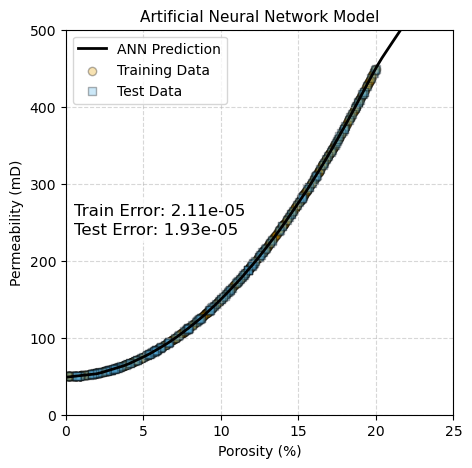

In [119]:
# Plot training and test data
plt.figure(figsize=(5, 5))
plt.plot(X_seq_true, y_seq_true, color="black", linewidth=2, label="ANN Prediction")
plt.scatter(X_train_true, y_train_true, c="#E69F00", alpha=0.3, edgecolors="black", label="Training Data", marker='o')
plt.scatter(X_test_true, y_test_true, c="#56B4E9", alpha=0.3, edgecolors="black", label="Test Data", marker='s')

plt.text(0.02, 0.55, f'Train Error: {train_mse:.2e}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
plt.text(0.02, 0.5, f'Test Error: {test_mse:.2e}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title("Artificial Neural Network Model", fontsize=11) # Titles and labels
plt.xlabel("Porosity (%)", fontsize=10); plt.ylabel("Permeability (mD)", fontsize=10)
plt.xlim([0, 25]); plt.ylim([0, 500])
plt.grid(True, linestyle='--', alpha=0.5); plt.legend(frameon=True, loc='upper left')
plt.show()

# plt.subplot(332)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title("ANN Training and Validation Loss", fontsize=11) # Titles and labels
# plt.xlabel("Epoch", fontsize=10); plt.ylabel("Mean Squared Error", fontsize=10)
# plt.xscale('log'); plt.yscale('log')
# plt.grid(which='both',linestyle='--', alpha=0.5); plt.legend()


# plt.subplot(333)
# plt.hist(error_train, facecolor='red',alpha=0.2,density=True,edgecolor='black',label='Train')
# plt.hist(error_test, facecolor='blue',alpha=0.2,density=True,edgecolor='black',label='Test')
# plt.xlabel('Model Error', fontsize=10); plt.ylabel('Frequency', fontsize=10); 
# plt.title('Training and Testing Error Distribution', fontsize=11)
# plt.legend(loc='upper right'); plt.grid(which='both',linestyle='--', alpha=0.5)

## Lab Functions
[🔝 Back to Outline](#outline)
> The following functions will be used in the workflow.

In [2]:
# DATA GENERATION FUNCTION
# -----------------------------------------------------------------------------------------------------------------------------------
# This function generates a synthetic dataset based on a polynomial function with added noise.

# Source: Dr. Michael Pyrcz (GeostatsGuy)
# https://github.com/GeostatsGuy/DataScienceInteractivePython/blob/main/Interactive_Overfit.ipynb
# Adapted from: "Interactive Overfit" Notebook

def data_generator(n: int, std: float, seed: int):
    """
    Generates a synthetic dataset based on a polynomial function with added noise.
    
    Parameters:
    - n (int): Number of data points.
    - split (float): Proportion of the dataset to include in the test split (e.g., 0.2 for 20% test data).
    - std (float): Standard deviation of the Gaussian noise added to the data.
    - seed (int): Random seed for reproducibility.
    
    Returns:
    - X (array): Predictor feature values.
    - y (array): Target values (response variable).
    """
    
    np.random.seed(seed)  # Seed the random number generator for reproducibility

    # Generate dataset
    X_seq = np.linspace(0, 20, 100)  # Sequence for plotting
    X = np.random.rand(n) * 20  # Generate random X values within the range [0, 20]
    
    # Create polynomial target values (quadratic function in this case)
    y = X ** 2 + 50.0  
    
    # Add Gaussian noise to the target variable
    y += np.random.normal(loc=0.0, scale=std, size=n)

    X_scaler = StandardScaler()
    X_scaled = X_scaler.fit_transform(X.reshape(-1, 1)).flatten()

    y_scaler = StandardScaler()
    y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

    return X_scaled, y_scaled, X_scaler, y_scaler



def split_data(X, y, test_size=0.2, seed=42, realization=0):
    """
    Splits the dataset into training and testing sets.

    Parameters:
    - X (array-like): Feature matrix.
    - y (array-like): Target variable.
    - test_size (float): Proportion of the dataset to include in the test split.
    - seed (int): Random seed for reproducibility.
    - realization (int): Value added to the seed for multiple realizations.

    Returns:
    - X_train, X_test, y_train, y_test: Split training and testing datasets.
    """

    return train_test_split(X, y, test_size=test_size, random_state=seed + realization)

In [3]:
# -----------------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------MODEL BUILDING FUNCTIONS-----------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------

# Code generated with the assistance of ChatGPT (OpenAI, 2025)
# and modified for clarity and functionality.
# The following functions are used to build a neural network model using Keras.

def input_layer(nodes: int, activation_function: str):
    """
    Creates an input layer for a neural network.

    Parameters:
    nodes (int): Number of neurons in the input layer.
    activation_function (str): Activation function to be used in the input layer.

    Returns:
    Dense: A Keras Dense layer with the specified number of nodes and activation function.
    """
    return Dense(nodes, activation=activation_function, input_shape=(1,))


def hidden_layer(nodes: int, activation_function: str):
    """
    Creates a hidden layer for a neural network.

    Parameters:
    nodes (int): The number of neurons in the hidden layer.
    activation_function (str): The activation function to be applied to the layer.

    Returns:
    Dense: A Keras Dense layer with the specified number of neurons and activation function.

    Example:
    >>> layer = hidden_layer(10, 'relu')
    >>> print(layer)
    <keras.src.layers.core.dense.Dense object at 0x...>
    """
    return Dense(nodes, activation=activation_function)


def output_layer():
    """
    Creates an output layer for a neural network.

    Returns:
    Dense: A Keras Dense layer with one neuron and a linear activation function.
    """
    return Dense(1, activation='linear')


def create_hidden_layers(model, num_layers: int, start_nodes: int, reduce_nodes: bool, activation_function: str, dropout_rate: float):
    """
    Adds hidden layers to a model with the option to either reduce or keep constant the number of neurons.

    Parameters:
    - model (Sequential): The Keras Sequential model to which the layers will be added.
    - num_layers (int): Number of hidden layers to add.
    - start_nodes (int): The number of neurons in the first hidden layer.
    - reduce_nodes (bool): If True, the number of neurons will decrease in each layer.
    - activation_function (str): The activation function to use for the hidden layers.

    Returns:
    - model (Sequential): The updated Keras Sequential model with added hidden layers.
    """
    
    for i in range(num_layers):
        if reduce_nodes:
            # Decrease the number of neurons by half in each layer
            nodes = max(1, int(start_nodes / (2 ** i)))  # Avoid going below 1 neuron
        else:
            # Keep the number of neurons constant
            nodes = start_nodes

        model.add(hidden_layer(nodes, activation_function))
        model.add(Dropout(dropout_rate))  # Add dropout layer
        # Add a dropout layer after each hidden layer

    return model


def build_model(input_nodes: int, input_activation: str,
                num_hidden_layers: int, hidden_nodes: int, reduce_nodes: bool = True, hidden_activation: str = 'relu', dropout_rate: float = 0.0,
                optimizer: str = 'adam', learning_rate: float = 0.01):
    
    """
    Builds a customizable neural network model using the Sequential API.

    This function creates a neural network model with a specified number of hidden layers, 
    customizable hidden node sizes (with an option for reducing nodes), activation functions, 
    and dropout regularization.

    Parameters:
    ----------
    input_nodes : int
        The number of nodes in the input layer.
    
    input_activation : str
        The activation function for the input layer (e.g., 'ReLU', 'sigmoid', 'tanh').
    
    num_hidden_layers : int
        The number of hidden layers to be added to the model.
    
    hidden_nodes : int
        The number of nodes in the first hidden layer. The number of nodes in subsequent 
        layers will decrease if `reduce_nodes` is set to True.
    
    reduce_nodes : bool, default=True
        Whether to reduce the number of nodes in each subsequent hidden layer. If False, 
        all hidden layers will have the same number of nodes as the first hidden layer.
    
    hidden_activation : str, default='ReLU'
        The activation function for all hidden layers (e.g., 'ReLU', 'sigmoid', 'tanh').
    
    dropout_rate : float, default=0.0
        The dropout rate applied to the hidden layers to prevent overfitting. A value between 0 and 1.

    optimizer : str, default='adam'
        The optimizer to use for training the model. Options include 'adam', 'sgd', 'adadelta', and 'rmsprop'.

    learning_rate : float, default=0.01
        The learning rate for the optimizer. This controls how much to change the model in response to the estimated error each time the model weights are updated.

    Returns:
    -------
    model : keras.Sequential
        A compiled Sequential model ready to be trained.
    """

    model = Sequential()
    # Add the input layer
    model.add(input_layer(input_nodes, input_activation))
    # Add hidden layers
    model = create_hidden_layers(model, num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate)
    # Add the output layer
    model.add(output_layer())

    # Choose optimizer based on input
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'Adadelta':
        opt = Adadelta(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mean_squared_error')

    return model

def train_model(model, X_train, y_train, epochs: int = 10, batch_size: int = 32, val=False):
    """
    Trains the neural network model on the provided training data.

    Parameters:
    ----------
    model : keras.Sequential
        The compiled Keras model to be trained.
    
    X_train : np.ndarray
        The input features for training.
    
    y_train : np.ndarray
        The target variable for training.
    
    epochs : int, default=10
        The number of epochs to train the model.
    
    batch_size : int, default=32
        The size of the batches used in training.

    Returns:
    -------
    history : keras.callbacks.History
        A History object containing details about the training process.
    """

    if val:
        # Split the data into training and validation sets
        X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        history = model.fit(X_train1, y_train1, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val))
        # Train the model with validation data
    else:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model, history



## Overfitting Lab Development
[🔝 Back to Outline](#outline)
> In the below workflow, I created a simple lab to study overfitting in ANN. Below are the follow steps taken to achieve it:
- Define sensitizing parameters.
- Create interactive widgets
- Build the model (The complex and compute resource demanding part of the workflow):
    - Defined dictionary to store realizations values
    - Loop through each hyperparameter to be sensitized on and store model values
    - Summary the value realized from the multiple realization of the sensitized hyperparameter
    - Build the desired model
    - Evaluate the model
- Plot desired results obtained after model training and evaluation
- Connect the interactive widgets 

In [4]:
# -----------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------HYPERPARAMETERS------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------
 
activation_functions_list = ['linear', 'relu', 'sigmoid', 'softmax', 'gelu']
reduce_nodes_list = [True, False]
node_sizes_list = [1, 2, 4, 8, 16, 32, 64, 128]
num_layers_list = [1, 2, 3, 4, 5]
dropout_rates_list = [0.0, 0.01, 0.03, 0.05, 0.075, 0.1, 0.2, 0.3]
epochs_list = [1, 10, 100, 1000]  # 5 epochs from 1 to 5
learning_rates_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
batch_sizes_list = [1, 2, 4, 8, 16, 32]
optimizers_list = ['SGD', 'Adam', 'Adadelta', 'RMSprop']

In [ ]:
# -----------------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------INTERACTIVE WIDGETS----------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------
title = widgets.Text(value='                                                                                            Artificial Neural Networked Overfitting Demo, Emmanuel Ikpesu, The University of Texas at Austin',
                 layout=Layout(width='1280px', height='30px'))

# data parameters
title_left = widgets.HTML(value="<b>📊 Data Parameters</b>")
n = widgets.IntSlider(min=15, max=80, value=30, step=1, description='Data Size (n)', style={'description_width': 'initial'})
split = widgets.FloatSlider(min=0.05, max=0.95, value=0.20, step=0.05, description='Test Split %', style={'description_width': 'initial'})
std = widgets.FloatSlider(min=0, max=50, value=0, step=1.0, description='Noise StDev', style={'description_width': 'initial'})



# Input layer parameters
title_input = widgets.HTML(value="<b>📥 Input Layer</b>")
input_activation = widgets.Dropdown(options=activation_functions_list,
                                       value='relu', description='Activation')
input_nodes = widgets.Dropdown(options=node_sizes_list, value=64, description='Nodes Per Layer')

title_hidden = widgets.HTML(value="<b>🤖 Hidden Layers</b>")
hidden_activation = widgets.Dropdown(options=activation_functions_list,
                                       value='relu', description='Activation')
reduce_nodes = widgets.ToggleButtons(options=reduce_nodes_list, value=True, description='Reduce Nodes')
hidden_nodes = widgets.Dropdown(options=node_sizes_list, value=128, description='Nodes Per Layer')
num_hidden_layers = widgets.IntSlider(min=1, max=4, value=2, step=1, description='Num Hidden Layers')
dropout_rate = widgets.FloatSlider(min=0.0, max=0.3, value=0.075, step=0.1, description='Dropout Rate')

# ANN hyperparameters
title_ann = widgets.HTML(value="<b>🧠 ANN Parameters</b>")
epochs = widgets.Dropdown(options=epochs_list, value=1000, description='Epochs')
learning_rate = widgets.Dropdown(options=learning_rates_list, value=0.01, description='Learning Rate')
batch_size = widgets.Dropdown(options=batch_sizes_list, value=4, description='Batch Size')
optimizer = widgets.Dropdown(options=optimizers_list, value='Adam', description='Optimizer')

data_column = widgets.VBox([title_left, n, split, std])
input_column = widgets.VBox([title_input, input_activation, input_nodes])
hidden_column = widgets.VBox([title_hidden, hidden_activation, hidden_nodes, num_hidden_layers, dropout_rate, reduce_nodes])
ann_column = widgets.VBox([title_ann, epochs, learning_rate, batch_size, optimizer])

model_details = widgets.Text(value=f'''                                                             The ANN Model Currently have {num_hidden_layers.value} 
Hidden Layers, Epoch of {epochs.value}, & {learning_rate.value} Learning Rate. For more details, please check the bottons above.''',
                            
                              
                 layout=Layout(width='1280px', height='30px'))



# Combine into two-column layout
ui = HBox([data_column, input_column, hidden_column, ann_column])
ui2 = VBox([title, ui, model_details])

In [6]:
# Source: Dr. Michael Pyrcz (GeostatsGuy)
# https://github.com/GeostatsGuy/DataScienceInteractivePython/blob/main/Interactive_Overfit.ipynb
# Adapted from: "Interactive Overfit" Notebook
def main(n, split, std, input_nodes, input_activation, num_hidden_layers, hidden_nodes, \
         reduce_nodes, hidden_activation, dropout_rate, optimizer, learning_rate, batch_size, epochs):


    # Number of realizations for the model sensitivity analysis
    # -----------------------------------------------------------------------------------------------------------------------------------
    nreal  = 4
    seed = 42
    np.random.seed(seed)                                   # set seed for reproducibility


    # -----------------------------------------------------------------------------------------------------------------------------------
    # --------------------------------------------------------HYPERPARAMETERS------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------------------------------------------
    
    activation_functions_list = ['linear', 'relu', 'sigmoid', 'softmax', 'gelu']
    reduce_nodes_list = [True, False]
    node_sizes_list = [1, 2, 4, 8, 16, 32, 64, 128]
    num_layers_list = [1, 2, 3, 4, 5]
    dropout_rates_list = [0.0, 0.01, 0.03, 0.05, 0.075, 0.1, 0.2, 0.3]
    epochs_list = [1, 10, 100, 1000]
    learning_rates_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
    batch_sizes_list = [1, 2, 4, 8, 16, 32]
    optimizers_list = ['SGD', 'Adam', 'Adadelta', 'RMSprop']


    # Generate data
    X_scaled, y_scaled, X_scaler, y_scaler = data_generator(n, std, seed)


    # Dictionary to store MSE results
    mse_results = {
        'hidden_node_sizes': 
            {'train': np.zeros([len(node_sizes_list), nreal])
            ,'test': np.zeros([len(node_sizes_list), nreal])},
        'num_layers': 
            {'train': np.zeros([len(num_layers_list), nreal])
            ,'test': np.zeros([len(num_layers_list), nreal])},
        'dropout_rates': 
            {'train': np.zeros([len(dropout_rates_list), nreal])
            ,'test': np.zeros([len(dropout_rates_list), nreal])},
        'epochs_list': 
            {'train': np.zeros([len(epochs_list), nreal])
            ,'test': np.zeros([len(epochs_list), nreal])},
        'learning_rates': 
            {'train': np.zeros([len(learning_rates_list), nreal])
            ,'test': np.zeros([len(learning_rates_list), nreal])},
        'batch_sizes': 
            {'train': np.zeros([len(batch_sizes_list), nreal])
            ,'test': np.zeros([len(batch_sizes_list), nreal])}   
    }

    #---------------------------------------------------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------Run Model Sensitivity----------------------------------------------------------
    for j in range(nreal):
        # Split data for each realization
        X_train, X_test, y_train, y_test = split_data(X_scaled, y_scaled, split, seed, j)

        # Test different Hidden node sizes
        for i, nodes in enumerate(node_sizes_list):
            model = build_model(input_nodes, input_activation,
                    num_hidden_layers, nodes, reduce_nodes, hidden_activation, dropout_rate,
                    optimizer, learning_rate)
            model, history = train_model(model, X_train, y_train, epochs, batch_size)
            y_train_pred = model.predict(X_train, verbose=0)
            y_test_pred = model.predict(X_test, verbose=0)
            mse_results['hidden_node_sizes']['train'][i, j] = mean_squared_error(y_train, y_train_pred)
            mse_results['hidden_node_sizes']['test'][i, j] = mean_squared_error(y_test, y_test_pred)

        # Test different number of layers
        for i, layers in enumerate(num_layers_list):
            model = build_model(input_nodes, input_activation,
                    layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate,
                    optimizer, learning_rate)
            model, history = train_model(model, X_train, y_train, epochs, batch_size)
            y_train_pred = model.predict(X_train, verbose=0)
            y_test_pred = model.predict(X_test, verbose=0)
            mse_results['num_layers']['train'][i, j] = mean_squared_error(y_train, y_train_pred)
            mse_results['num_layers']['test'][i, j] = mean_squared_error(y_test, y_test_pred)
            

        # Test different dropout rates
        for i, dropout in enumerate(dropout_rates_list):
            model = build_model(input_nodes, input_activation,
                    num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout,
                    optimizer, learning_rate)
            model, history = train_model(model, X_train, y_train, epochs, batch_size)
            y_train_pred = model.predict(X_train, verbose=0)
            y_test_pred = model.predict(X_test, verbose=0)
            mse_results['dropout_rates']['train'][i, j] = mean_squared_error(y_train, y_train_pred)
            mse_results['dropout_rates']['test'][i, j] = mean_squared_error(y_test, y_test_pred)


        # Test different number of epochs
        for i, epoch_value in enumerate(epochs_list):
            model = build_model(input_nodes, input_activation,
                    num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate,
                    optimizer, learning_rate)
            model, history = train_model(model, X_train, y_train, epoch_value, batch_size)
            y_train_pred = model.predict(X_train, verbose=0)
            y_test_pred = model.predict(X_test, verbose=0)
            mse_results['epochs_list']['train'][i, j] = mean_squared_error(y_train, y_train_pred)
            mse_results['epochs_list']['test'][i, j] = mean_squared_error(y_test, y_test_pred)

        # Test different learning rates
        for i, lr in enumerate(learning_rates_list):
            model = build_model(input_nodes, input_activation,
                    num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate,
                    optimizer, lr)
            model, history = train_model(model, X_train, y_train, epochs, batch_size)
            y_train_pred = model.predict(X_train, verbose=0)
            y_test_pred = model.predict(X_test, verbose=0)
            mse_results['learning_rates']['train'][i, j] = mean_squared_error(y_train, y_train_pred)
            mse_results['learning_rates']['test'][i, j] = mean_squared_error(y_test, y_test_pred)

        # Test different batch sizes
        for i, batch in enumerate(batch_sizes_list):
            model = build_model(input_nodes, input_activation,
                    num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate,
                    optimizer, learning_rate)
            model, history = train_model(model, X_train, y_train, epochs, batch)
            y_train_pred = model.predict(X_train, verbose=0)
            y_test_pred = model.predict(X_test, verbose=0)
            mse_results['batch_sizes']['train'][i, j] = mean_squared_error(y_train, y_train_pred)
            mse_results['batch_sizes']['test'][i, j] = mean_squared_error(y_test, y_test_pred)


    mse_summary = {}

    for key, value in mse_results.items():
        mse_summary[key] = {}
        for subset in ['train', 'test']:
            mse_matrix = value[subset]
            mse_summary[key][subset] = {
                'mean': np.mean(mse_matrix, axis=1).flatten(),
                'high': np.percentile(mse_matrix, 90, axis=1),
                'low': np.percentile(mse_matrix, 10, axis=1)
            }


    #---------------------------------------------------------------------------------------------------------------------------------------------
    #------------------------------------------------------Model Building and Training Required Mode----------------------------------------------

    # build the one model example to show
    X_train, X_test, y_train, y_test = split_data(X_scaled, y_scaled, split, seed, 0)
    model = build_model(input_nodes, input_activation,
                    num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate,
                    optimizer, learning_rate)
    model, history = train_model(model, X_train, y_train, epochs, batch_size, val=True)

    # calculate error
    y_train_pred = model.predict(X_train, verbose=0) # predict training data
    y_test_pred = model.predict(X_test, verbose=0) # predict test data


    error_train = y_train_pred.flatten() - y_train # calculate error on training data
    error_test = y_test_pred.flatten() - y_test # calculate error on test data

    # calculate model curve
    X_seq = np.linspace(-3,3,100)
    y_seq = model.predict(X_seq, verbose=0) # predict model curve


    #---------------------------------------------------------------------------------------------------------------------------------------------
    #---------------------------------------------------------------Results Visualization--------------------------------------------------
    #---------------------------------------------------------------------------------------------------------------------------------------------

    plt.figure(figsize=(10, 21))
    plt.subplot(331)
    # Plot model predictions
    X_train_true = X_scaler.inverse_transform(X_train.reshape(-1, 1)).flatten()
    X_test_true = X_scaler.inverse_transform(X_test.reshape(-1, 1)).flatten()
    y_train_true = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_test_true = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    X_seq_true = X_scaler.inverse_transform(X_seq.reshape(-1, 1)).flatten()
    y_seq_true = y_scaler.inverse_transform(y_seq.reshape(-1, 1)).flatten()
    plt.plot(X_seq_true, y_seq_true, color="black", linewidth=2, label="ANN Prediction")
    # Plot training and test data
    plt.scatter(X_train_true, y_train_true, c="red", alpha=0.3, edgecolors="black", label="Training Data")
    plt.scatter(X_test_true, y_test_true, c="blue", alpha=0.3, edgecolors="black", label="Test Data")
    plt.title("Artificial Neural Network Model", fontsize=11) # Titles and labels
    plt.xlabel("Porosity (%)", fontsize=10); plt.ylabel("Permeability (mD)", fontsize=10)
    plt.xlim([0, 25]); plt.ylim([0, 500])
    plt.grid(True, linestyle='--', alpha=0.5); plt.legend(frameon=True, loc='upper left')

    plt.subplot(332)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("ANN Training and Validation Loss", fontsize=11) # Titles and labels
    plt.xlabel("Epoch", fontsize=10); plt.ylabel("Mean Squared Error", fontsize=10)
    plt.xscale('log'); plt.yscale('log')
    plt.grid(which='both',linestyle='--', alpha=0.5); plt.legend()


    plt.subplot(333)
    plt.hist(error_train, facecolor='red',alpha=0.2,density=True,edgecolor='black',label='Train')
    plt.hist(error_test, facecolor='blue',alpha=0.2,density=True,edgecolor='black',label='Test')
    plt.xlabel('Model Error', fontsize=10); plt.ylabel('Frequency', fontsize=10); 
    plt.title('Training and Testing Error Distribution', fontsize=11)
    plt.legend(loc='upper right'); plt.grid(which='both',linestyle='--', alpha=0.5)


    plt.subplot(334)
    epoch_summary = mse_summary['epochs_list']
    train_avg = epoch_summary['train']['mean']; train_high = epoch_summary['train']['high']; train_low = epoch_summary['train']['low']
    test_avg = epoch_summary['test']['mean']; test_high = epoch_summary['test']['high']; test_low = epoch_summary['test']['low']
    ax = plt.gca()
    plt.plot(epochs_list,train_avg,lw=2,label='Train',c='red')
    ax.fill_between(epochs_list,train_high,train_low,facecolor='red',alpha=0.05)
    plt.plot(epochs_list,test_avg,lw=2,label='Test',c='blue')  
    ax.fill_between(epochs_list,test_high,test_low,facecolor='blue',alpha=0.05)
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Complexity - No_of_epochs'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Epochs)')
    combined_error = np.concatenate((train_avg, test_avg), axis=0)
    plt.plot([epochs,epochs],[max(combined_error)*1.95,min(combined_error)*0.05],c = 'black',linewidth=3,alpha = 0.8)
    plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)


    plt.subplot(335)
    hidden_node_summary = mse_summary['hidden_node_sizes']
    train_avg = hidden_node_summary['train']['mean']; train_high = hidden_node_summary['train']['high']; train_low = hidden_node_summary['train']['low']
    test_avg = hidden_node_summary['test']['mean']; test_high = hidden_node_summary['test']['high']; test_low = hidden_node_summary['test']['low']
    ax = plt.gca()
    plt.plot(node_sizes_list,train_avg,lw=2,label='Train',c='red')
    ax.fill_between(node_sizes_list,train_high,train_low,facecolor='red',alpha=0.05)
    plt.plot(node_sizes_list,test_avg,lw=2,label='Test',c='blue')  
    ax.fill_between(node_sizes_list,test_high,test_low,facecolor='blue',alpha=0.05)
    plt.xlabel('Complexity - # Starting Hidden Node'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (# Hidden-Nodes)')
    combined_error = np.concatenate((train_avg, test_avg), axis=0)
    plt.plot([hidden_nodes,hidden_nodes],[max(combined_error)*1.95,min(combined_error)*0.05],c = 'black',linewidth=3,alpha = 0.8)
    plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)


    plt.subplot(336)
    num_layers_summary = mse_summary['num_layers']
    train_avg = num_layers_summary['train']['mean']; train_high = num_layers_summary['train']['high']; train_low = num_layers_summary['train']['low']
    test_avg = num_layers_summary['test']['mean']; test_high = num_layers_summary['test']['high']; test_low = num_layers_summary['test']['low']
    ax = plt.gca()
    plt.plot(num_layers_list,train_avg,lw=2,label='Train',c='red')
    ax.fill_between(num_layers_list,train_high,train_low,facecolor='red',alpha=0.05)
    plt.plot(num_layers_list,test_avg,lw=2,label='Test',c='blue')  
    ax.fill_between(num_layers_list,test_high,test_low,facecolor='blue',alpha=0.05)
    plt.xlabel('Complexity - # Hidden Layers'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (# Hidden-Layers)')
    combined_error = np.concatenate((train_avg, test_avg), axis=0)
    plt.plot([num_hidden_layers,num_hidden_layers],[max(combined_error)*1.95,min(combined_error)*0.05],c = 'black',linewidth=3,alpha = 0.8)
    plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)


    plt.subplot(337)
    dropout_rates_summary = mse_summary['dropout_rates']
    train_avg = dropout_rates_summary['train']['mean']; train_high = dropout_rates_summary['train']['high']; train_low = dropout_rates_summary['train']['low']
    test_avg = dropout_rates_summary['test']['mean']; test_high = dropout_rates_summary['test']['high']; test_low = dropout_rates_summary['test']['low']
    ax = plt.gca()
    plt.plot(dropout_rates_list,train_avg,lw=2,label='Train',c='red')
    ax.fill_between(dropout_rates_list,train_high,train_low,facecolor='red',alpha=0.05)
    plt.plot(dropout_rates_list,test_avg,lw=2,label='Test',c='blue')  
    ax.fill_between(dropout_rates_list,test_high,test_low,facecolor='blue',alpha=0.05)
    plt.xlabel('Complexity - Dropout Rate'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Dropout Rate)')
    combined_error = np.concatenate((train_avg, test_avg), axis=0)
    plt.plot([dropout_rate,dropout_rate],[max(combined_error)*1.95,min(combined_error)*0.05],c = 'black',linewidth=3,alpha = 0.8)
    plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)

    plt.subplot(338)
    learning_rates_summary = mse_summary['learning_rates']
    train_avg = learning_rates_summary['train']['mean']; train_high = learning_rates_summary['train']['high']; train_low = learning_rates_summary['train']['low']
    test_avg = learning_rates_summary['test']['mean']; test_high = learning_rates_summary['test']['high']; test_low = learning_rates_summary['test']['low']
    ax = plt.gca()
    plt.plot(learning_rates_list,train_avg,lw=2,label='Train',c='red')
    ax.fill_between(learning_rates_list,train_high,train_low,facecolor='red',alpha=0.05)
    plt.plot(learning_rates_list,test_avg,lw=2,label='Test',c='blue')  
    ax.fill_between(learning_rates_list,test_high,test_low,facecolor='blue',alpha=0.05)
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Complexity - Learning Rate'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Learning Rate)')
    combined_error = np.concatenate((train_avg, test_avg), axis=0)
    plt.plot([learning_rate,learning_rate],[max(combined_error)*1.95,min(combined_error)*0.05],c = 'black',linewidth=3,alpha = 0.8)
    plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)

    plt.subplot(339)
    batch_sizes_summary = mse_summary['batch_sizes']
    train_avg = batch_sizes_summary['train']['mean']; train_high = batch_sizes_summary['train']['high']; train_low = batch_sizes_summary['train']['low']
    test_avg = batch_sizes_summary['test']['mean']; test_high = batch_sizes_summary['test']['high']; test_low = batch_sizes_summary['test']['low']
    ax = plt.gca()
    plt.plot(batch_sizes_list,train_avg,lw=2,label='Train',c='red')
    ax.fill_between(batch_sizes_list,train_high,train_low,facecolor='red',alpha=0.05)
    plt.plot(batch_sizes_list,test_avg,lw=2,label='Test',c='blue')  
    ax.fill_between(batch_sizes_list,test_high,test_low,facecolor='blue',alpha=0.05)
    plt.xlabel('Complexity - Batch Size'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Batch Size)')
    combined_error = np.concatenate((train_avg, test_avg), axis=0)
    plt.plot([batch_size,batch_size],[max(combined_error)*1.95,min(combined_error)*0.05],c = 'black',linewidth=3,alpha = 0.8)
    plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)


    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.2, hspace=0.3)


    plt.show()

In [7]:
# WARNING: The following code may take a while to run, depending on the parameters selected.
# It take minimum of 16 minutes to run on a standard laptop.
#---------------------------------------------------------------------------------------------------------------------------------------------

# Source: Dr. Michael Pyrcz (GeostatsGuy)
# https://github.com/GeostatsGuy/DataScienceInteractivePython/blob/main/Interactive_Overfit.ipynb
# Adapted from: "Interactive Overfit" Notebook

# Connect the function to the widgets
interactive_ann = widgets.interactive_output(
    main,
    {
        'n': n,
        'split': split,
        'std': std,
        'input_nodes': input_nodes,
        'input_activation': input_activation,
        'num_hidden_layers': num_hidden_layers,
        'hidden_nodes': hidden_nodes,
        'reduce_nodes': reduce_nodes,
        'hidden_activation': hidden_activation,
        'dropout_rate': dropout_rate,
        'optimizer': optimizer,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'epochs': epochs
    }
)

# Optional: reduce flicker
interactive_ann.clear_output(wait=True)

## Overfitting Lab Interactive Demonstration
[🔝 Back to Outline](#outline)

> Change the number of sample data, train/test split, data noise, and model structure to observe overfitting!
Modify model layers, training parameters, and activations to explore ANN performance.

**Data Parameters**
- n: Number of data samples
- Test %: Percentage of sample data withheld as testing data
- Noise StDev: Standard deviation of random Gaussian error added to the data

**Input Layer**
- input_nodes: Number of input nodes
- input_activation: Activation function used in the input layer

**Hidden Layers**
- num_hidden_layers: Number of hidden layers
- hidden_nodes: Number of nodes per hidden layer
- reduce_nodes: Option to reduce the number of nodes with depth
- hidden_activation: Activation function used in the hidden layers
- dropout_rate: Fraction of dropout applied between layers (0 to 0.9)

**Training Parameters**
- optimizer: Optimizer used to update weights (e.g., adam, sgd, rmsprop)
- learning_rate: Step size for the optimizer during backpropagation
- batch_size: Number of samples per gradient update
- epochs: Number of full training cycles over the dataset

In [8]:
# Source: Dr. Michael Pyrcz (GeostatsGuy)
# https://github.com/GeostatsGuy/DataScienceInteractivePython/blob/main/Interactive_Overfit.ipynb
# Adapted from: "Interactive Overfit" Notebook

# It take minimum of 10 minutes to run on a standard laptop.
display(ui2, interactive_ann)                           # display the interactive plot

Output()

## Observations
[🔝 Back to Outline](#outline)
1. **Model Performance (Top-Left Plot)**
The ANN successfully learns the underlying trend in porosity prediction. The training and testing data generally follow the same trend, with minimal overfitting.

2. **Loss Curves (Top-Center Plot)**
The training and validation loss both decrease smoothly, indicating good convergence. However, the slight gap between them suggests mild overfitting as complexity increases.

3. **Error Distribution (Top-Right Plot)**
The error distribution for training and testing shows a small spread around the mean, confirming model stability. Yet, testing errors display a longer tail, highlighting some variance in generalization.

4. **Hyperparameter Sensitivity (Bottom 6 Plots)**:
    - **Epochs**: Error decreases with more epochs, then plateaus, showing that training for too few epochs leads to underfitting, while too many may not add value.
    - **Hidden Nodes**: Increased nodes reduce error until diminishing returns or slight overfitting set in beyond ~100 nodes.
    - **Hidden Layers**: Adding more layers initially improves performance, but after 3–4 layers, test error rises, showing increased overfitting.
    - **Dropout Rate**: Moderate dropout (e.g., 0.1–0.2) helps regularize the model. Too much dropout leads to higher error.
    - **Learning Rate**: Performance is sensitive to learning rate. Very small or large rates perform poorly. An optimal middle ground exists (~1e-3).
    - **Batch Size**: Larger batch sizes lead to higher test error, indicating they may hurt generalization for this dataset.

## Conclusion
This ANN Lab demonstrates the impact of model complexity and training parameters on overfitting and generalization. While increasing layers, nodes, and epochs can reduce training error, it must be balanced with regularization techniques like dropout and careful tuning of batch size and learning rate.

> **Pro Tip: Use sensitivity plots to visually compare different hyperparameter settings. Look for the point where test error is minimized and the gap between training and testing error is smallest — this helps you identify the sweet spot between underfitting and overfitting.**

In practice, this lab highlights the **importance of iterative tuning and validation** when developing ANN models for geoscientific applications like porosity estimation.





<To Do> 

## About The Author
[🔝 Back to Outline](#outline)

Emmanuel Ikpesu is a first-year PhD student at the [Hildebrand Department of Petroleum and Geosystems Engineering](https://www.pge.utexas.edu/) at [The University of Texas at Austin](https://www.utexas.edu/), within the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p). His research focuses on the integration of **Artificial Intelligence (AI), computational techniques, and information engineering** to address complex challenges in the energy sector, under the guidance of [Professor John T. Foster](https://www.pge.utexas.edu/faculty-and-staff/john-foster/). Currently, Emmanuel is investigating serpentinization processes for **in-situ hydrogen production**, specifically exploring how fractures form in this context, merging AI with physics to uncover novel solutions.

Emmanuel brings over **4 years of combined experience** in **data science, data engineering, and reservoir engineering**. He has worked on both upstream oil and gas challenges and large-scale commercial analytics projects.

At AB-InBev, he led the optimization and migration of a major data pipeline to Azure, cutting refresh times by 66% and saving the company over 200% in operational costs — one of the company’s standout analytics achievements during his tenure.

Outside academia and industry, Emmanuel is passionate about **democratizing data skills**. He shares **free, beginner-friendly content** on **data science** and **data engineering** via [LinkedIn](https://www.linkedin.com/in/emmanuel-ikpesu-393708132/) and [Twitter/X](https://twitter.com/thedatahokage) , aiming to make technical knowledge more accessible to learners around the world.

### Open to Collaborations & Internships 🤝
I hope this lab and its resources are helpful to students, educators, and professionals interested in artificial intelligence, data science, and their applications in subsurface modeling and energy systems. I'm always excited to connect, collaborate, and learn.

Are you working on innovative problems at the intersection of AI and the energy sector? I’m open to collaborative research, project-based partnerships, and internship opportunities where I can contribute and grow.

If you’re looking for someone with experience in machine learning, data analytics, and energy modeling—especially someone who’s enthusiastic about combining physics-informed AI with real-world impact—feel free to reach out!

📬 You can contact me at emmanuel.ikpesu@utexas.edu.

Let’s build something meaningful together!



## About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)